# Generating white-box models for interpretable classification and regression

The field of Explainable AI (XAI) contains a wide variety of approaches, depending on the desired outcome. There are approaches which provide information directly about the data, while others attempt to explain the behavior of certain models, which represent mapping between the data and a designated target variable.

The main goal of model explanation (which falls into the latter category described above) is to provide insight into the origins of the outputs given by a predictive model. This can be achieved in two main ways: (1) either we produce a model, which is in it's core explainable (so its prediction process can be easily understood), or (2) we try to explain the behavior of an originally non-explainable (or black-box) model with some explainability technique.

In this demonstration, we will focus on the first approach into model explanation, namely by producing white-box models, which are directly explainable due to their simplicity and transparency. 

## Simple white-box models

Some of the earliest statistical methods used to accomplish regression and classification tasks tend to have somewhat explainable properties, due to their inherent simplicity.

For example, linear regression produces predictions in the following manner:

$$ y = \bf{wx}^T + \rm{b}$$

where $\bf{x}^T$ is the value of the input variables in the form of a column vector, $\bf{w}$ is the row vector representing the weight parameters, and $b$ is the intercept (or bias). In this case, the individual weights in the vector $\bf{w}$ directly represent the change in the output for a fixed amount of change in the corresponding input variable. Therefore, these values provide a direct explanation for the predictions of the linear model, if the input variables have the same range (e.g. they are normalized between $0$ and $1$).

On a similar note for classification tasks, we can extract the decision rules for every class in a DNF form by tracking back the root node from every leaf, and considering the conjunction of the literals in every node as a clause of the DNF condition for the class in question.

## Boolean Decision Rules via Column Generation (BRCG)

Decision trees (as discussed in the previous section) have desirable explainability properties, assuming that they have a small enough maximum depth. However, the training of decision trees is a greedy process, which always makes a decision where the resulting information gain is maximal. 

A more informed approach is provided by the method named Boolean Decision Rules via Column Generation, or BRCG for short, which is described in detail in a paper by Sanjeeb et al. which can be accessed via the following link in a PDF format: 

https://papers.nips.cc/paper/2018/file/743394beff4b1282ba735e5e3723ed74-Paper.pdf

In short, the goal of the BRCG method is to find a logical expression in DNF (Disjunctive Normal Form) form, which offers a compromise between classification accuracy and rule complexity. In order to implement this, the method formulates the objective as an integer program (IP):

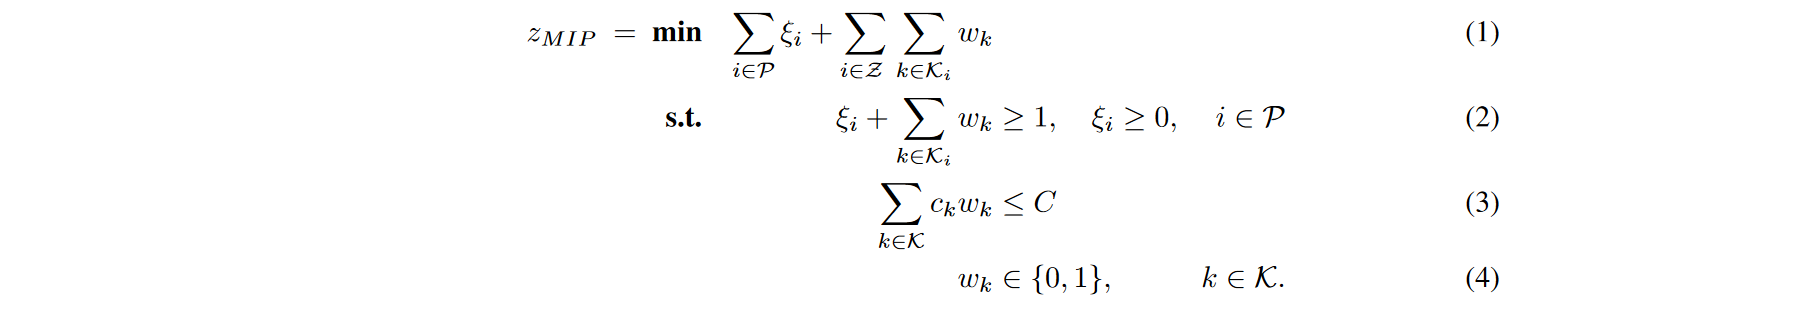

where:
- $\mathcal{P}$ denotes the set of all positive examples and $\mathcal{Z}$ denotes all negative examples in the dataset
- $\xi_i$ is equal to $1$ if the positive sample $i$ is classified incorrectly, otherwise $0$
- $\mathcal{K}$ denotes the set of all possible clauses (exponentially many) that can be formed using the features of the (binary) dataset
- $\mathcal{K}_i \in \mathcal{K}$ is the set of the clauses satisfied by the sample $i$
- $w_k$ is equal to $1$ if the clause $k$ is included in the current model, otherwise $0$
- $c_k$ denotes the complexity value of clause $k$
- $C$ is the upper bound on complexity

The loss function basically gives the total number of samples classified incorrectly, therefore it is equivalent to the Hamming loss, while constraint $(3)$ gives an upper bound to complexity. Moreover, constraint $(2)$ ensures that for every positive sample $i \in \mathcal{P}$, either there is at least one conjunction in the DNF which is satisfied by that sample, or otherwise the sample is classified incorrectly, therefore $\xi_i = 1$. Finally, conjunction $(4)$ enforces a strictly integer solution.

This integer program (as all integer programs in general) is NP-complete, therefore providing an optimal solution for large datasets would be computationally infeasible, and even if we reduce the problem into a linear program – by dropping constraint $(4)$ – solving for $w_k, k \in \mathcal{K}$ can still be intractable because of the exponential number of clauses in $\mathcal{K}$.

To resolve the issue of computational infeasibility, the authors of the BRCG method came up with an approximate solution, where they use an iteratively expanding set of possible literals (variables), therefore limiting the size of $\mathcal{K}$, and reducing the LP relaxation of the original IP, which they named Restricted MLP. To aid this solution, they devised a metric called "reduced cost", which shows how the addition of a new clause to the Restricted MLP would modify its objective function in a best case scenario, which is as follows:

$$R_k = \sum_{i \in \mathcal{Z}}\delta_{ki} - \sum_{i \in \mathcal{P}} \mu_i \delta_{ki} + \lambda c_k$$

where:
- $\mathcal{Z}$ is the set of all negative samples, and $\mathcal{P}$ is the set of all positive samples
- $\delta_{ki}=1$ if the conjunction $k$ is satisfied by sample $i$, otherwise $\delta_{ki}=0$
- $\mu_i \geq 0$ for $i \in \mathcal{P}$ denotes the dual variables associated with constraint $(2)$ in the LP form of the original IP
- $\lambda \geq 0$ is the regularization term, and also the dual variable associated with $(3)$
- $c_k$ is the complexity of conjunction $k$, which is equal to $1 + |k|$, where $|k|$ denotes the number of literals in conjunction $k$

With the reduced cost metric defined, the BRCG algorithm consists of the following steps:
1. Start with an empty variable set $\mathcal{J}=\emptyset$
2. For every variable $j \in (X)$ (where $X$ is the set of all variables) if $j \notin \mathcal{J}$ form a temporary variable set $\mathcal{T}_j := \mathcal{J} \cup j$, and find the lowest $R_k$ value using all conjunctions that can be formed from the variables in $\mathcal{T}_j$, let this lowest $R_k$ value for variable $j$ denoted by $R_k^{(j)}$
3. If there is no variable $j \in (X)$ for which $j \notin \mathcal{J}$ and $R_k^{(j)} < 0$, then no possible extension of $\mathcal{J}$ would lower the objective function of the Restricted MLP, so the algorithm terminates
4. Otherwise, add the variable $j \notin \mathcal{J}$ with the lowest $R_k^{(j)}$ value to the variable set: $\mathcal{J} := \mathcal{J} \cup j$
5. Calculate the new DNF solution to the Restricted MLP using the current variable set $\mathcal{J}$, then return to step 2

The authors of the BRCG method claim that the solution produced by the above algorithm for the Restricted MLP is an optimal solution for the original LP problem, and if the optimal solution of the Restricted MLP turns out to be integral, then it is also an optimal solution for the original IP. If the optimal solution is fractional, then $\lceil z_{MLP} \rceil$ provides a lower bound for the solution of the original IP.

The final result is a boolean rule in DNF form, and the compromise between accuracy and complexity can be controlled by setting the value of the regularization parameter ($\lambda$), and the upper bound on complexity ($C$).

## Generalized Linear Rule Models

The Generalized Linear Rule Models, or GLRM method can be most easily described as an extension of the BRCG algorithm for regression problems. The result of this method is provided as a set of clauses, a corresponding set of coefficients, and an intercept (bias) value. During its operation, the model summarizes the intercept value and all coefficients where the corresponding clause is true based on the input data, thus providing the output. In a more formal manner, the regression output for input $i$ is provided as:

$$y_i = \sum_{k\in \mathcal{K}}\beta_k a_{ik} + \mathcal{I}$$

where: 
- $\mathcal{K}$ represents the set of clauses in the model
- $\beta_k$ is the coefficient for the clause $k$
- $a_{ik}$ is the indicatior variable, which is $1$ if sample $i$ satisfies clause $k$, and $0$ otherwise
- $\mathcal{I}$ is the intercept value (similar to the bias in linear regression)

For example, if we have three rules (clauses), and corresponding coefficients:

- $k_1=\{x_1<5,x_2>3\}\quad\beta_1=-6$
- $k_2=\{x_2<5,x_3=0\}\quad\beta_2=8$
- $k_3=\{x_3=1\}\quad\beta_3=2$

and the intercept is $\mathcal{I}=-2$, then the model's output for $\{x_1=3,x_2=4,x_3=0\}$ is:

$$y=a_1\beta_1 + a_2\beta_2 + a_3\beta_3 + \mathcal{I} = 1*(-5) + 1*8 + 0*2 + (-2) = 2$$

If the rule set is known, then the coefficients and the intercept can be determined by minimizing the error of the output given the training data. The rule set is estimated by a similar integer program that has been used in the BRCG algorithm, with the main difference being the objective function. The exact optimization algorithm is described in detail in the following paper by Wei et. al.:

http://proceedings.mlr.press/v97/wei19a/wei19a.pdf

Similar to the BRCG method, GLRM provides an explainable algorithm (for regression, this time) where the compromise between complexity and accuracy can be controlled using regularization terms that increase the value of the objective function based on the number of rules (clauses) and literals used inside the model.

# Demonstration

After a brief introduction into the theory of the BRCG and GLRM methods, let us demonstrate these techniques on a real-life dataset, using the AIX360 framework developed by IBM Research.

First, import some basic dependencies, and define the location of the dataset:

In [1]:
import pandas as pd
import numpy as np

DATASET_FOLDER = "data"

## Load and inspect the dataset

We use the Adult Census Income dataset from Kaggle (https://www.kaggle.com/datasets/uciml/adult-census-income)

This dataset contains some basic information (e.g. marital status, employment, education, ethnicity, etc...) of US citizens, based on the data gathered from the 1994 US census.
The original goal of this dataset is to attempt to estimate the household income of US workers, therefore it does not contain people who are unemployed or under the age of 16.

Although this dataset has been artificially generated for obvious privacy reasons, the distribution of the data is representative of the US population, as of 1994.

In [2]:
data_load = pd.read_csv(DATASET_FOLDER + "/adult_reconstruction.csv")

data_load.head(5)

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial


## Data preprocessing

First, we remove all rows with missing values, then delete the "education" column, which is redundant since the "education-num" represents the same information, but as an ordinal variable:

In [3]:
missing_mask = np.logical_not(np.any((data_load == "?").to_numpy(), axis=1))
data_cleaned = data_load.iloc[missing_mask, :]
data_cleaned = data_cleaned.drop(columns=["education"])

Split the dataset to train and test data, and also separate our target variable:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data_cleaned.drop(columns=["income"]), data_cleaned["income"], test_size = 0.2, random_state = 42)

## Binarization

Then, we create a binarized version of our target variable for classification. In our case, the first task will be to predict who has an income higher than 30.000\\$:

In [5]:
Y_train_b = (Y_train > 30000).astype(int)
Y_test_b = (Y_test > 30000).astype(int)

Check if the training and test data are well balanced:

In [6]:
print(f"Train labels distribution: {Y_train_b.mean():.4f}")
print(f"Test labels distribution:  {Y_test_b.mean():.4f}")

Train labels distribution: 0.4591
Test labels distribution:  0.4635


The data seems to be balanced, which is not surprising, since the 30.000\\$ threshold is close to the median US household income (which was around 27.000\\$ in 1994).

Then, we have to binarize all features, by quantizing all continuous variables, then converting the (now fully categorical) dataset into a one-hot encoded format.

For feature binarization, we have two options presented by the `aix360` framework:
- The normal `FeatureBinarizer`, which quantizes the continuous features in a roughly equal manner, so every category contains around the same number of samples.
- The `FeatureBinarizerFromTrees`, which uses decision trees, or more precisely, the splits made by decision trees (based on the resulting information gain) to determine the quantization thresholds for continuous variables, and to reduce the number of categories for categorical variables.

### Equally distributed binarization

First, let's observe the results of the simple `FeatureBinarizer`:

In [7]:
from aix360.algorithms.rbm import FeatureBinarizer

fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(X_train)
X_test_fb = fb.transform(X_test)

We left the `negations` flag of the binarizer in it's default `True` state, so it will also produce the negated version of every binary variable. Although this doubles the number of features generated, therefore going against compactness, it will also help the formulation of decision rules in DNF form by both the BRCG and GLRM algorithms.

Here, we can inspect the new representation of the `age` variable, which has been quantized into roughly equal sized bins:

In [8]:
X_train_fb["age"].head(5)

operation   <=                                            >                 \
value     22.0 26.0 30.0 33.0 37.0 41.0 45.0 50.0 57.0 22.0 26.0 30.0 33.0   
20480        0    0    1    1    1    1    1    1    1    1    1    0    0   
13010        1    1    1    1    1    1    1    1    1    0    0    0    0   
31191        0    0    0    0    0    1    1    1    1    1    1    1    1   
7069         0    0    0    0    1    1    1    1    1    1    1    1    1   
4867         0    0    0    0    1    1    1    1    1    1    1    1    1   

operation                           
value     37.0 41.0 45.0 50.0 57.0  
20480        0    0    0    0    0  
13010        0    0    0    0    0  
31191        1    0    0    0    0  
7069         0    0    0    0    0  
4867         0    0    0    0    0

And we can also observe the number of features (variables) after quantization:

In [9]:
print(f'{X_train_fb.shape[1]} features.')

206 features.


### Binarization using decision trees

Now, let us perform the binarization using decision trees:

In [10]:
from aix360.algorithms.rbm import FeatureBinarizerFromTrees

fbt = FeatureBinarizerFromTrees(treeNum=10, treeDepth=5, threshround=0,
                                randomState=42)
X_train_fbt = fbt.fit_transform(X_train, Y_train_b)
X_test_fbt = fbt.transform(X_test)

As we can see, the number of quantization levels for the `age` variable have been reduced by one-third, and their values are presumably more useful to predict the target variable:

In [11]:
X_train_fbt["age"].head(5)

operation   <=                             >                         
value     23.5 24.5 26.5 27.5 28.5 37.5 23.5 24.5 26.5 27.5 28.5 37.5
20480        0    0    0    1    1    1    1    1    1    0    0    0
13010        1    1    1    1    1    1    0    0    0    0    0    0
31191        0    0    0    0    0    0    1    1    1    1    1    1
7069         0    0    0    0    0    1    1    1    1    1    1    0
4867         0    0    0    0    0    1    1    1    1    1    1    0

On the other hand, the total number of features in the binarized dataset have been reduced by more than 75%:

In [12]:
print(f'{X_train_fbt.shape[1]} features.')

48 features.


Because runtime and memory cost of both the BRCG and GLRM methods increase drastically with the number of features provided, we will train them using the data binarized using decision trees, which has significantly reduced dimensionality.

With this said, you (the reader) are free to inspect the behavior of the following methods using the original binarized data, given you have the patience to wait for the training to finish.

## The BRCG method

In order to train our boolean classifier, first we import the necessary classes:

In [13]:
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG
import time

import warnings
warnings.filterwarnings('ignore')

Then, instantiate the classifier using arbitrary lambda parameters, and fit it to our training data. These parameters represent the regularization weights, therefore giving the user control over the compromise between performance and simplicity. Increasing the value of these terms will result in a simpler model, consisting of less clauses and a smaller number of literals, but will decrease the classification accuracy. Logically, decreasing the value of the regularization parameters will have an opposite effect.

In this case, the regularization parameters directly affect the metric which evaluates the maximum possible improvment that the addition of a variable could mean for the objective function of the original integer program.

In [14]:
boolean_model = BooleanRuleCG(lambda0=0.001, # Complexity - fixed cost of each clause
                              lambda1=0.001, # Complexity - additional cost for each literal
                              silent=False)
boolean_explainer = BRCGExplainer(boolean_model)
start_time = time.time()
boolean_explainer.fit(X_train_fbt, Y_train_b)
print(f"Model trained under {(time.time() - start_time):.2f} seconds.")

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2278
Iteration: 2, Objective: 0.2227
Iteration: 3, Objective: 0.2200
Iteration: 4, Objective: 0.2131
Iteration: 5, Objective: 0.2126
Iteration: 6, Objective: 0.2126
Model trained under 46.27 seconds.


Next we evaluate the predictive performance of the classifier, using the test dataset:

In [15]:
Y_pred_b_train = boolean_explainer.predict(X_train_fbt)
Y_pred_b_test = boolean_explainer.predict(X_test_fbt)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Train Accuracy = {accuracy_score(Y_train_b, Y_pred_b_train):.4f}')
print(f' Test Accuracy = {accuracy_score(Y_test_b, Y_pred_b_test):.4f}')
print(f'     Precision = {precision_score(Y_test_b, Y_pred_b_test):.4f}')
print(f'        Recall = {recall_score(Y_test_b, Y_pred_b_test):.4f}')
print(f'            F1 = {f1_score(Y_test_b, Y_pred_b_test):.4f}')

Train Accuracy = 0.7952
 Test Accuracy = 0.7893
     Precision = 0.8031
        Recall = 0.7226
            F1 = 0.7607


And finally, we can inspect the BDF rules used for classification, in a human-readable form:

In [17]:
e = boolean_explainer.explain()
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'
print(isCNF if e['isCNF'] else notCNF)
print()
for rule in e['rules']:
    print(f'  - {rule}')
print()

Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - capital-gain > 4533.00
  - age > 37.50 AND education-num > 12.50
  - age > 27.50 AND education-num > 8.50 AND hours-per-week > 37.50 AND marital-status == Married-civ-spouse



For reference, an additional notebook (`random_forest_demo.ipynb`) has been provided for the same data, which implements a black-box model of high complexity, namely a random forest classifier, with 50 decision trees. The performance of this complex, non-explainable classifier has only been 2-3% higher compared to the BRCG classifier demonstrated above, with a simple logical rule consisting of only 3-4 clauses.

## The GLRM method

Next we will demonstrate the GLRM method, which we will use to estimate the household income as a regression task.

In order to do this, first we import the necessary classes:

In [18]:
from aix360.algorithms.rbm import GLRMExplainer, LinearRuleRegression
import time

Then, we instantiate the regression model with arbitrary regularization parameters, then fit it to the training data. (this time, using the continuous income variable as the target)

Here, the regularization parameters play a similar rule as in the BRCG method, where they give the user control over the compromise between complexity and predictive performance, with complexity being the number of rules (clauses) and literals. In this case, the rules are the same:
- higher regularization: lower complexity (better explainability) in the cost of performance
- lower regularization: higher complexity (worse explainability) but better predictive performance

In [19]:
linear_model = LinearRuleRegression(lambda0=0.4,  # Complexity - fixed cost of each rule (clause)
                                    lambda1=0.02) # Complexity - additional cost for each literal
linear_explainer = GLRMExplainer(linear_model)
start_time = time.time()
linear_explainer.fit(X_train_fbt, Y_train)
print(f"Training finished under {(time.time() - start_time):.2f} seconds")

Training finished under 2.42 seconds


Next, we evaluate the predictive performance of the regression model on the test dataset:

In [20]:
Y_pred_train = linear_explainer.predict(X_train_fbt)
Y_pred_test = linear_explainer.predict(X_test_fbt)

In [21]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, max_error
print(f'          R2 Score = {r2_score(Y_test, Y_pred_test):.4f}')
print(f'Explained Variance = {explained_variance_score(Y_test, Y_pred_test):.4f}')
print(f'   Mean abs. error = {mean_absolute_error(Y_test, Y_pred_test):.2f}')
print(f'         Max error = {max_error(Y_test, Y_pred_test):.2f}')

          R2 Score = 0.5328
Explained Variance = 0.5331
   Mean abs. error = 13606.89
         Max error = 77072.87


And finally, we can inspect the final rules that the model has created, in a simple tabular form:

In [22]:
from IPython.display import display, HTML

explanation = linear_explainer.explain()
display(HTML(explanation.to_html()))

,rule,coefficient
0,(intercept),24568
1,marital-status == Married-civ-spouse,31854.3
2,capital-gain <= 4533.00 AND education-num <= 12.50,-24704.3
3,age > 27.50 AND education-num > 8.50 AND hours-per-week > 34.00 AND occupation != Other-service,17113.4
4,education-num <= 12.50 AND marital-status != Married-civ-spouse,14990.7
5,capital-gain <= 4533.00 AND education-num <= 12.50 AND hours-per-week <= 40.50,-6106.86
6,age > 27.50 AND education-num > 8.50 AND marital-status == Married-civ-spouse,3150.49


The operation of the model is fairly simple: to produce the result, simply evaluate the truth value of all rules (clauses), then summarize the coefficients where the corresponding rule is true. The intercept is a rule which is always true, therefore it provides a similar functionality as the "bias" parameter in linear regression.

As an additional thought, we can also examine the distribution of errors on the test dataset:

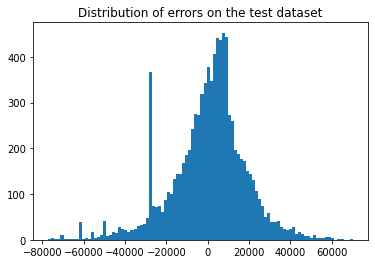

In [23]:
from matplotlib import pyplot as plt

test_errors = Y_pred_test - Y_test

plt.figure()
plt.hist(test_errors, bins=100)
plt.title("Distribution of errors on the test dataset")
plt.show()

Finally, for the sake of completeness, a reference random forest regressor is also provided in the `random_forest_demo.ipynb` notebook, in a similar way as it has been in the previous BRCG section. The reference black-box model has produced a 15% better predictive performance on the same data. In this case, as it has been mentioned before, the prediction accuracy can be improved for the price of higher complexity.